In [ ]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

In [1]:
from music21 import corpus
# Now try training on more bach
paths = corpus.getComposer('mozart')
len(paths)

16

In [2]:
from tqdm import tqdm
from music21 import corpus, metadata, note, stream

all_states = set()
all_pitches = set()
all_durations = set()
training_data = []
chord_occurence_count = 0
note_count = 0
for p in tqdm(paths):
    # Load the score
    s = corpus.parse(p)
    
    soprano_part = None
    for part in s.parts:
        if "Soprano" in (part.partName or ""):  # Check for 'Soprano' in the part name
            soprano_part = part
            break
    
    # Fallback if no explicit Soprano part is named
    if soprano_part is None:
        # Assume the first part is the Soprano if no explicit naming is found
        soprano_part = s.parts[0]
    
    # Extract notes and rests (pitch and duration)
    notes_sequence = []
    for element in soprano_part.flat.notesAndRests:  # Include notes and rests
        if element.isNote:
            notes_sequence.append((element.pitch.nameWithOctave, element.quarterLength))
        elif element.isChord:        
            # If there's a chord, take the highest note (melodic line usually uses the top note)
            #notes_sequence.append((element.highestNote.nameWithOctave, element.quarterLength))

            # Get the bass (lowest) note of the chord
            bass_note = element.bass()
            notes_sequence.append((bass_note.nameWithOctave, element.quarterLength))

            chord_occurence_count += 1
        elif element.isRest:
            notes_sequence.append(('Rest', element.quarterLength))

    notes = []
    for pitch, duration in notes_sequence:    
        all_pitches.add(pitch)
        all_durations.add(duration)
        s = (pitch, duration)
        if pitch == 'Rest':
            notes.append(note.Rest(quarterLength=s[1]))
            #ignore rests for now
            #pass
        else:
            notes.append(note.Note(s[0], quarterLength=s[1]))        
        all_states.add(s)    
    training_data.append(notes)
    note_count += len(notes)

/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead        | 0/16 [00:00<?, ?it/s]
  return self.iter().getElementsByClass(classFilterList)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.49it/s]


In [3]:
note_count, chord_occurence_count, len(training_data)

(7845, 64, 16)

In [4]:
len(all_states), len(all_pitches)

(394, 56)

In [5]:
print(sorted(all_pitches))

['A#3', 'A#4', 'A#5', 'A-4', 'A-5', 'A3', 'A4', 'A5', 'B#4', 'B-3', 'B-4', 'B-5', 'B3', 'B4', 'B5', 'C#4', 'C#5', 'C#6', 'C-5', 'C-6', 'C4', 'C5', 'C6', 'D#4', 'D#5', 'D#6', 'D-4', 'D-5', 'D-6', 'D4', 'D5', 'D6', 'E#5', 'E-4', 'E-5', 'E-6', 'E4', 'E5', 'E6', 'F#4', 'F#5', 'F#6', 'F-5', 'F4', 'F5', 'F6', 'G#3', 'G#4', 'G#5', 'G-4', 'G-5', 'G3', 'G4', 'G5', 'G6', 'Rest']


In [6]:
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator
model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(all_states))

In [7]:
%%time
model.train(training_data)

CPU times: user 42.4 ms, sys: 2.76 ms, total: 45.2 ms
Wall time: 15 ms


In [8]:
%%time
generated_melody = model.generate(30)

CPU times: user 2.52 ms, sys: 443 μs, total: 2.96 ms
Wall time: 805 μs


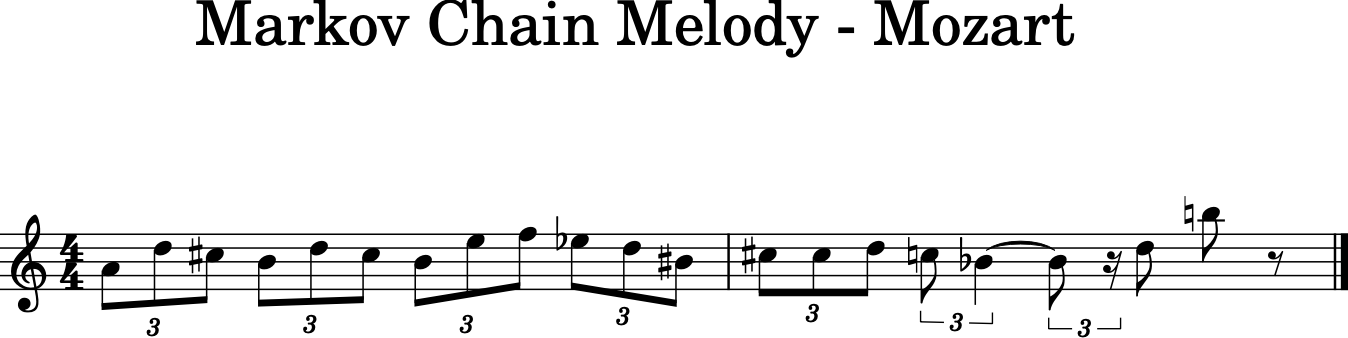

In [10]:
generated_melody, _ = model.generate(20)

from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Mozart")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

In [11]:
%%time
full_melody, new_part = model.generate(30, previous_sequence=generated_melody)

CPU times: user 2.76 ms, sys: 760 μs, total: 3.52 ms
Wall time: 3.11 ms


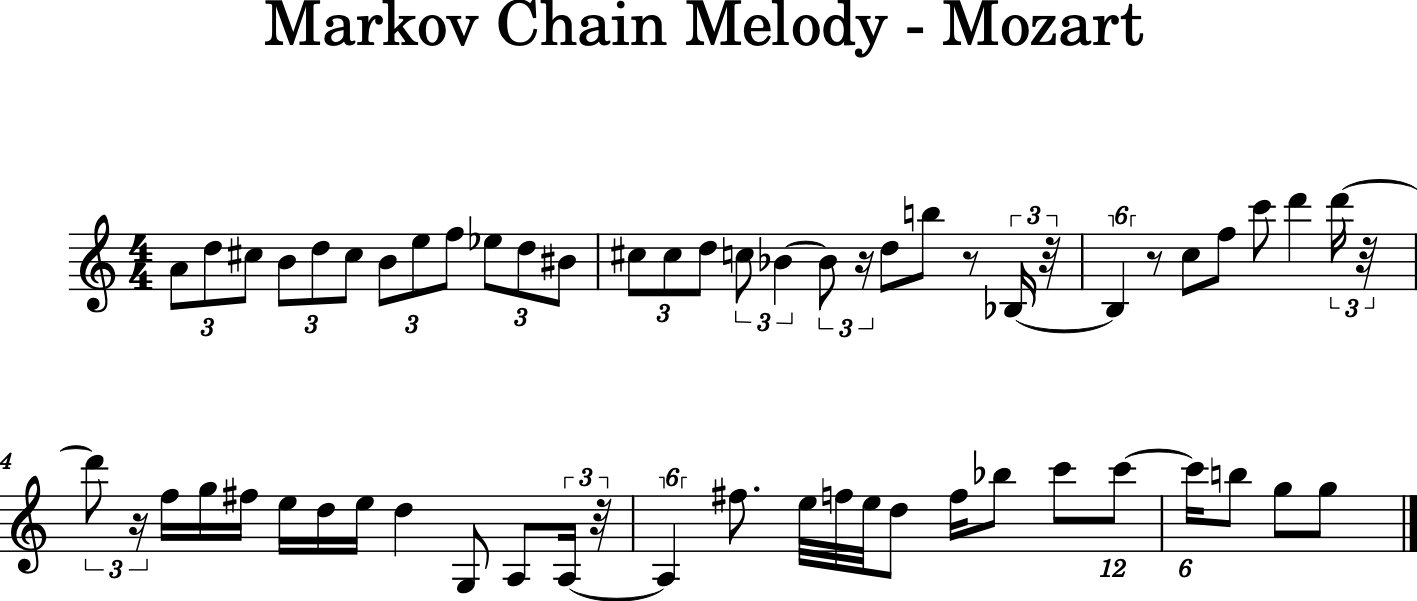

In [12]:
from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Mozart")
part = stream.Part()
for n, d in full_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

In [13]:
input_melody = [("C5", 1.0), ("D5", 1.0), ("E5", 1.0), ("F5", 1.0), ("G5", 1.0), ("A5", 1.0), ("C5", 2.0), ("D5", 2.0), ("E5", 2.0), ("F5", 2.0), ("G5", 2.0), ("A5", 2.0)]

In [14]:
%%time
full_melody, new_part = model.generate(30, previous_sequence=input_melody)

CPU times: user 2.39 ms, sys: 1.46 ms, total: 3.85 ms
Wall time: 3.32 ms


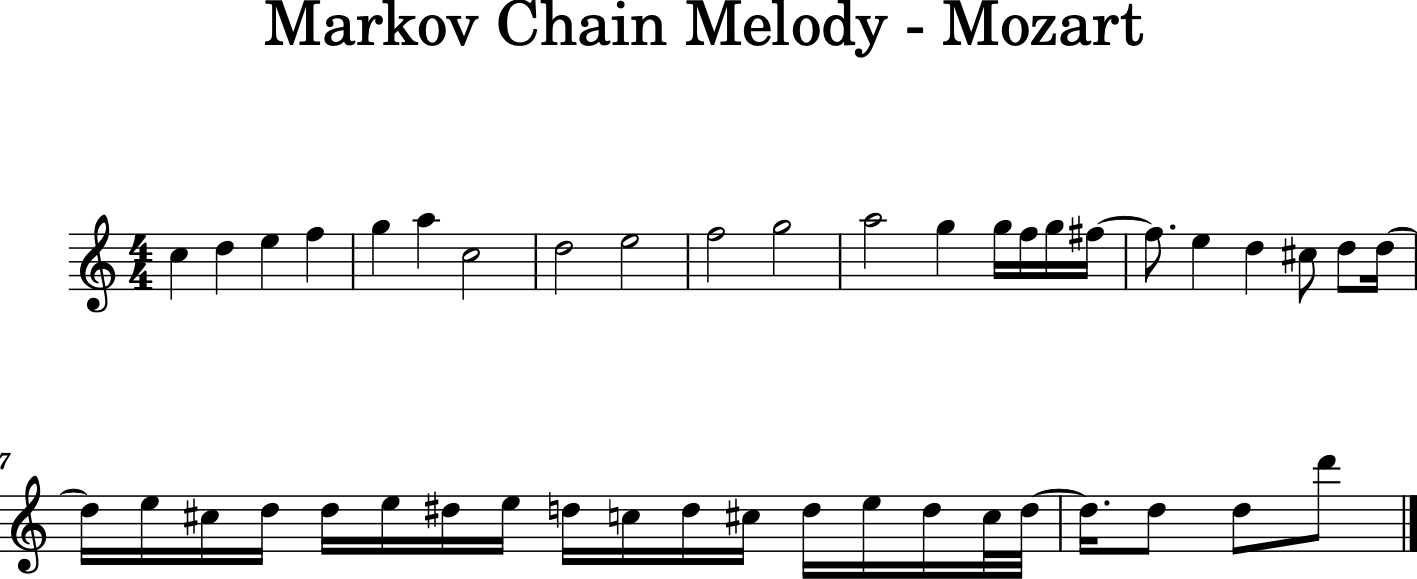

In [15]:
from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Mozart")
part = stream.Part()
for n, d in full_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

In [18]:
input_melody = [("C5", 1.0), ("C5", 1.0), ("G5", 1.0), ("G5", 1.0), ("A5", 1.0), ("A5", 1.0), ("G5", 2.0)]

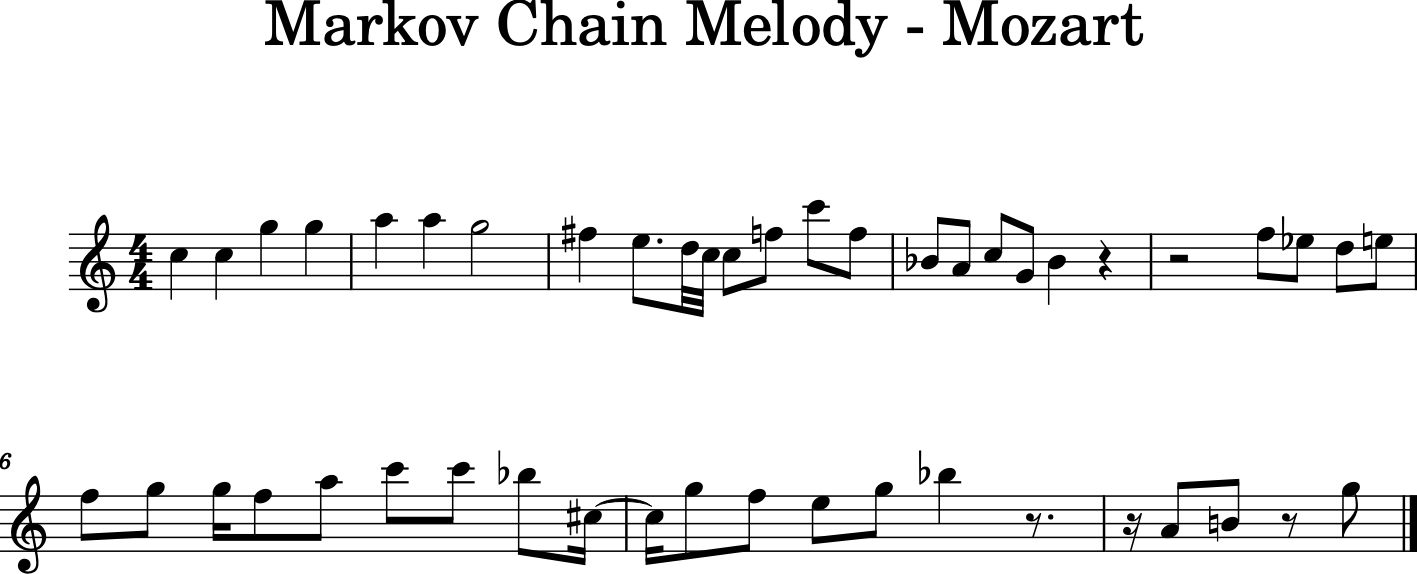

In [20]:
full_melody, new_part = model.generate(20, previous_sequence=input_melody)

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Mozart")
part = stream.Part()
for n, d in full_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()